In [1]:
from IPython.display import Image

- references
    - https://medium.com/@vishnuvijayanpv/deep-reinforcement-learning-artificial-intelligence-machine-learning-and-deep-learning-e52cb5974420
    - https://openai.com/research/instruction-following

## basics


- `WithValueHead`
    - `AutoModelForCausalLMWithValueHead`
    ```
    (v_head): ValueHead(
        (dropout): Dropout(p=0.1, inplace=False)
        (summary): Linear(in_features=768, out_features=1, bias=True)
        (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    ```
    
    - `AutoModelForCausalLMWithValueHead` & `AutoModelForSeq2SeqLMWithValueHead`: A transformer model with an additional scalar output for each token which can be used as a value function in reinforcement learning.
    
- `reward model`


- loss
    - policy loss
    - value loss
    - entropy loss

```
def step(
    self,
    queries: List[torch.LongTensor],
    responses: List[torch.LongTensor],
    scores: List[torch.FloatTensor],
):
```

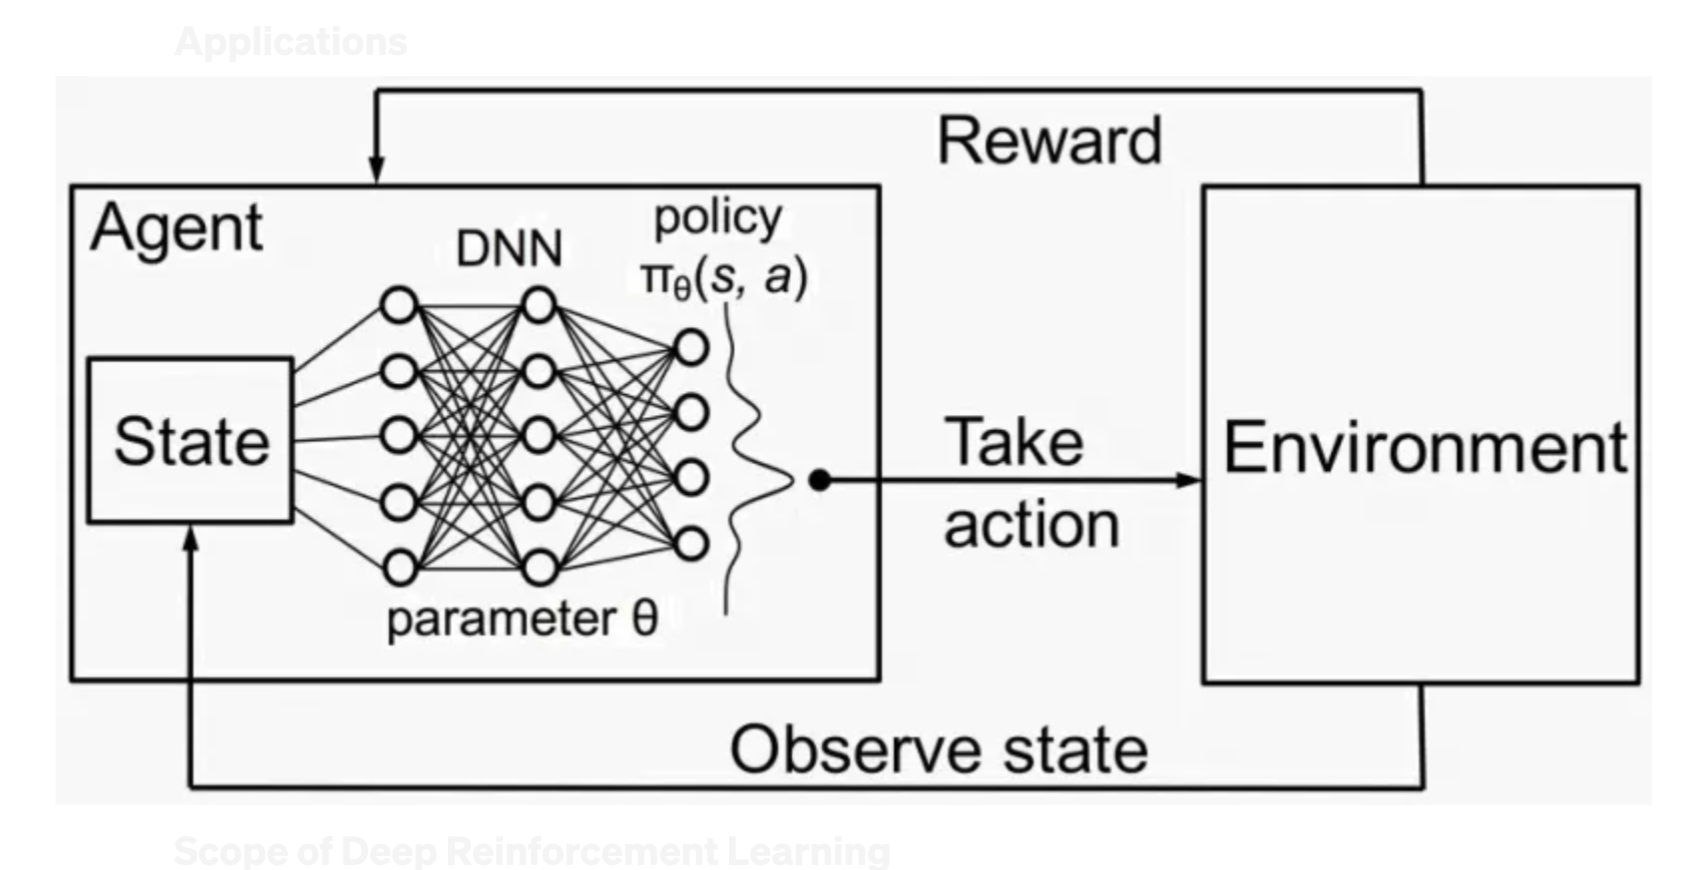

In [2]:
Image('../imgs/drl.png', width=400)

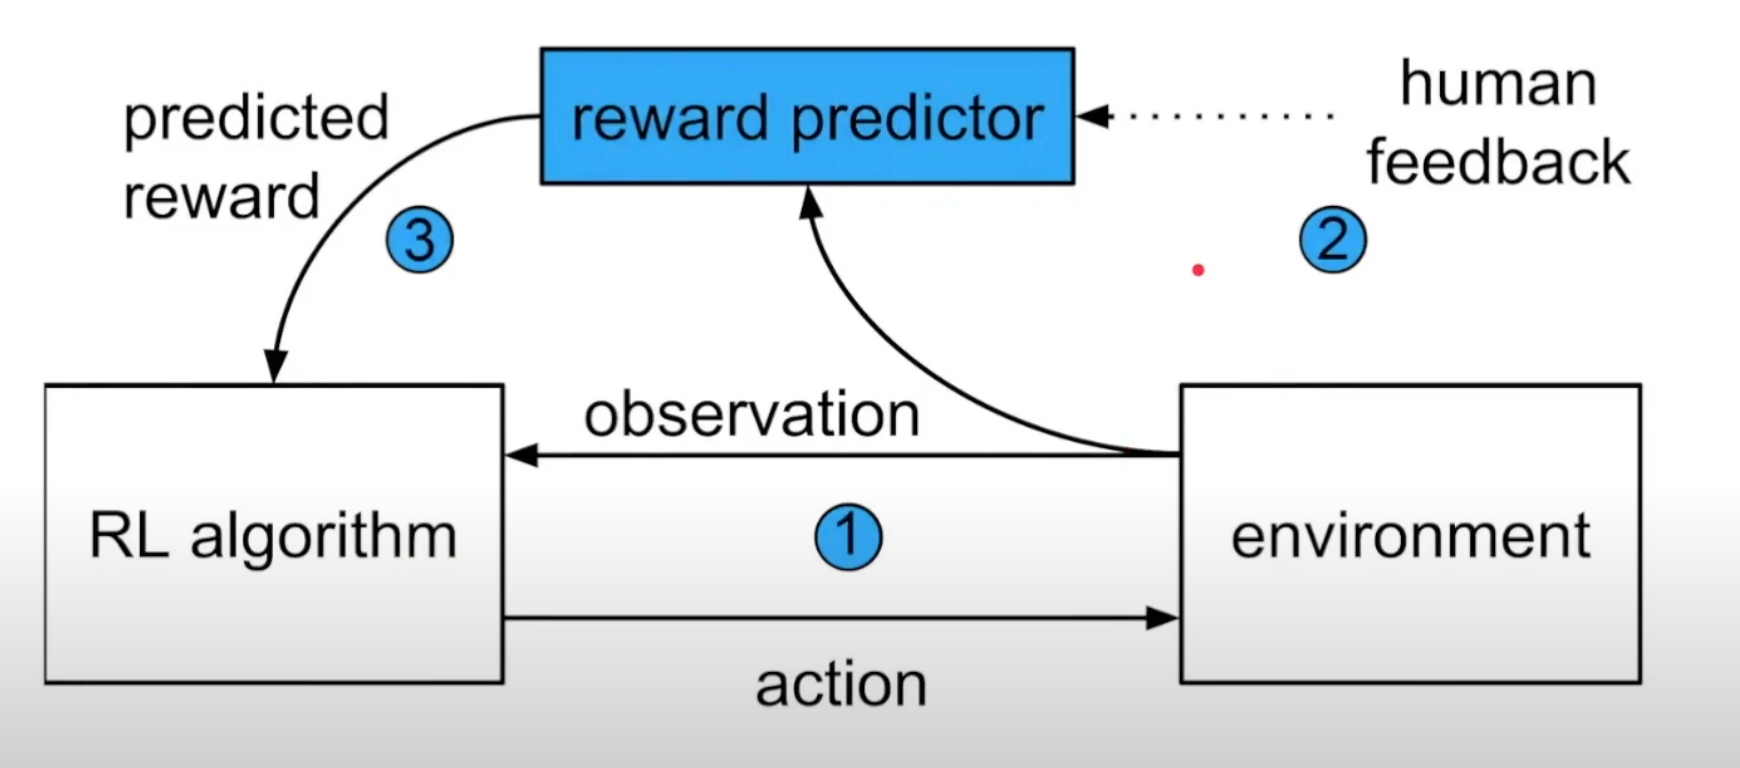

In [3]:
Image('../imgs/rlhf.png', width=400)

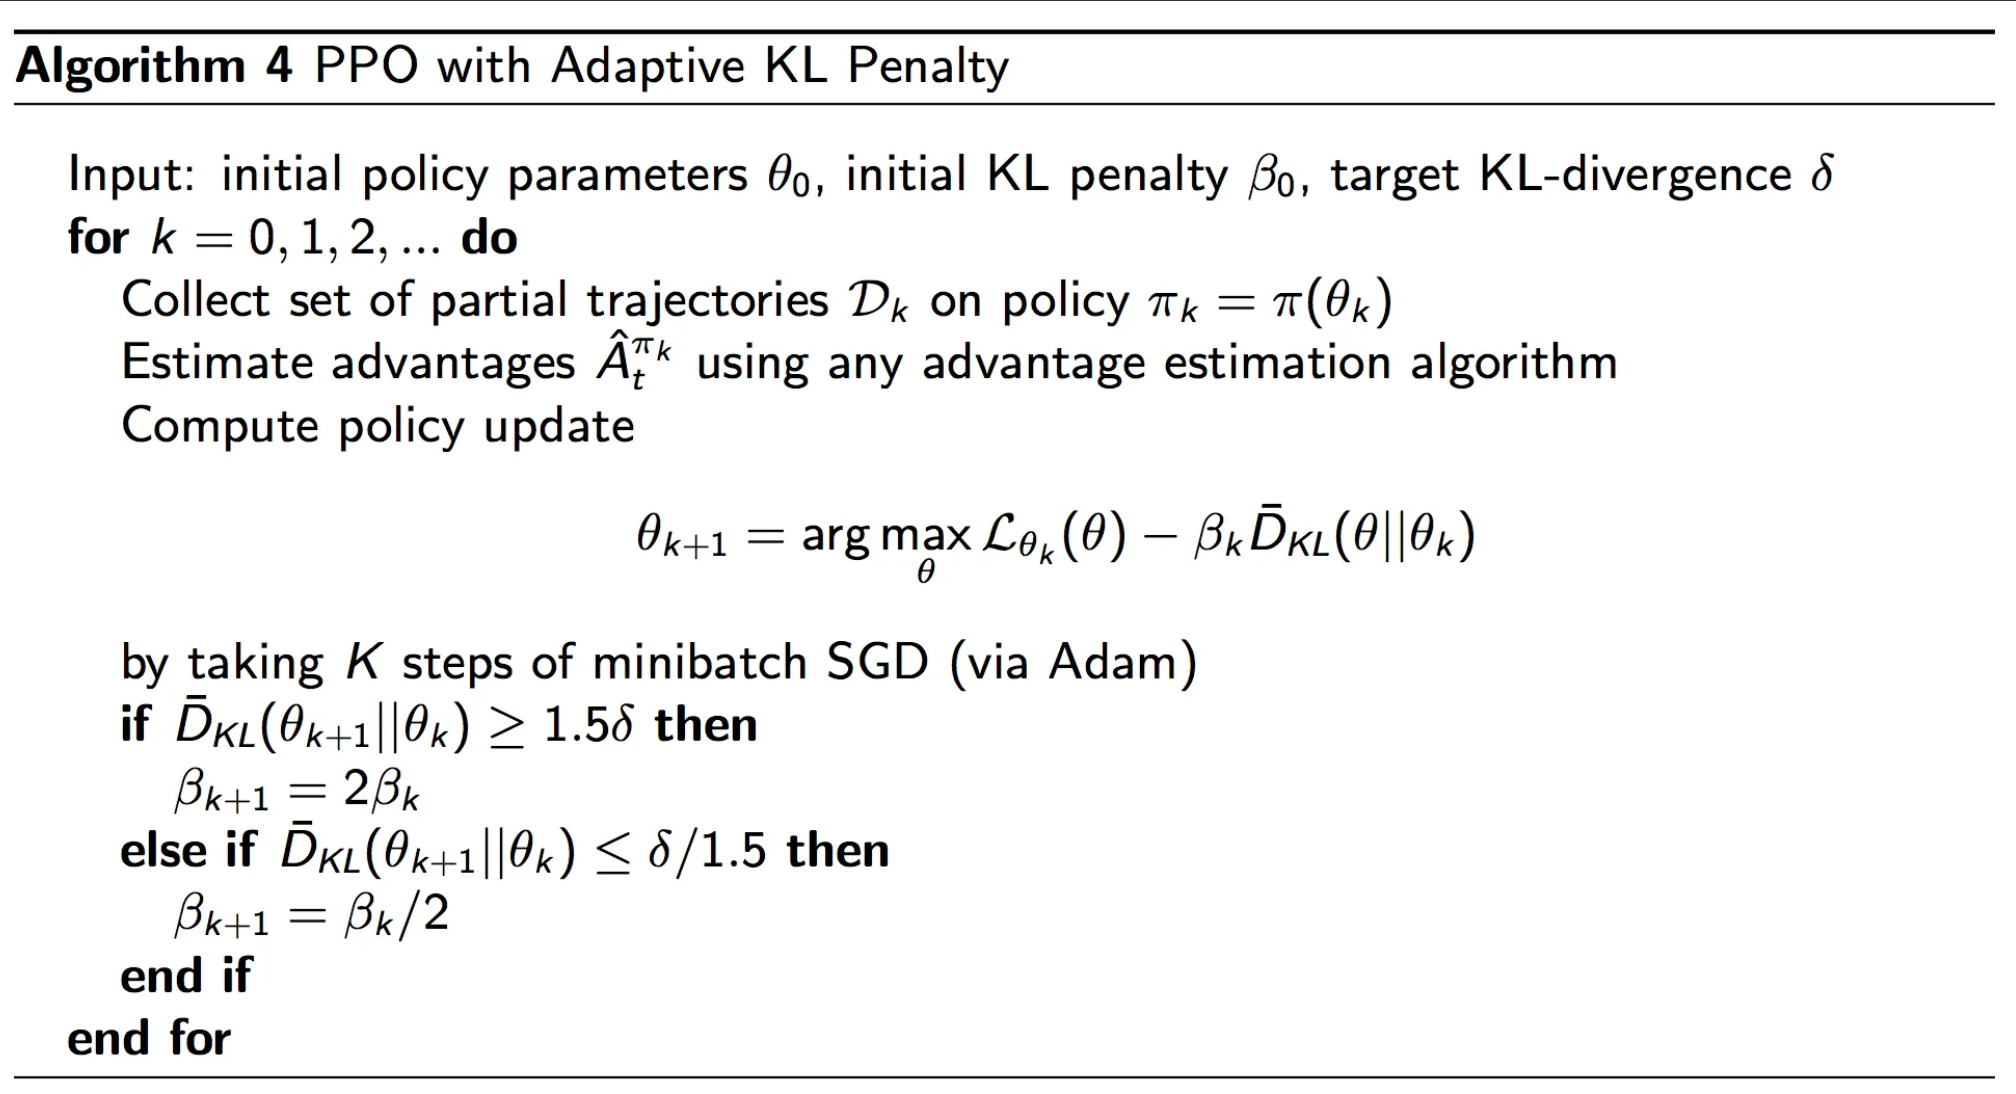

In [4]:
Image('../imgs/ppo_algo.png', width=600)

## 一个例子

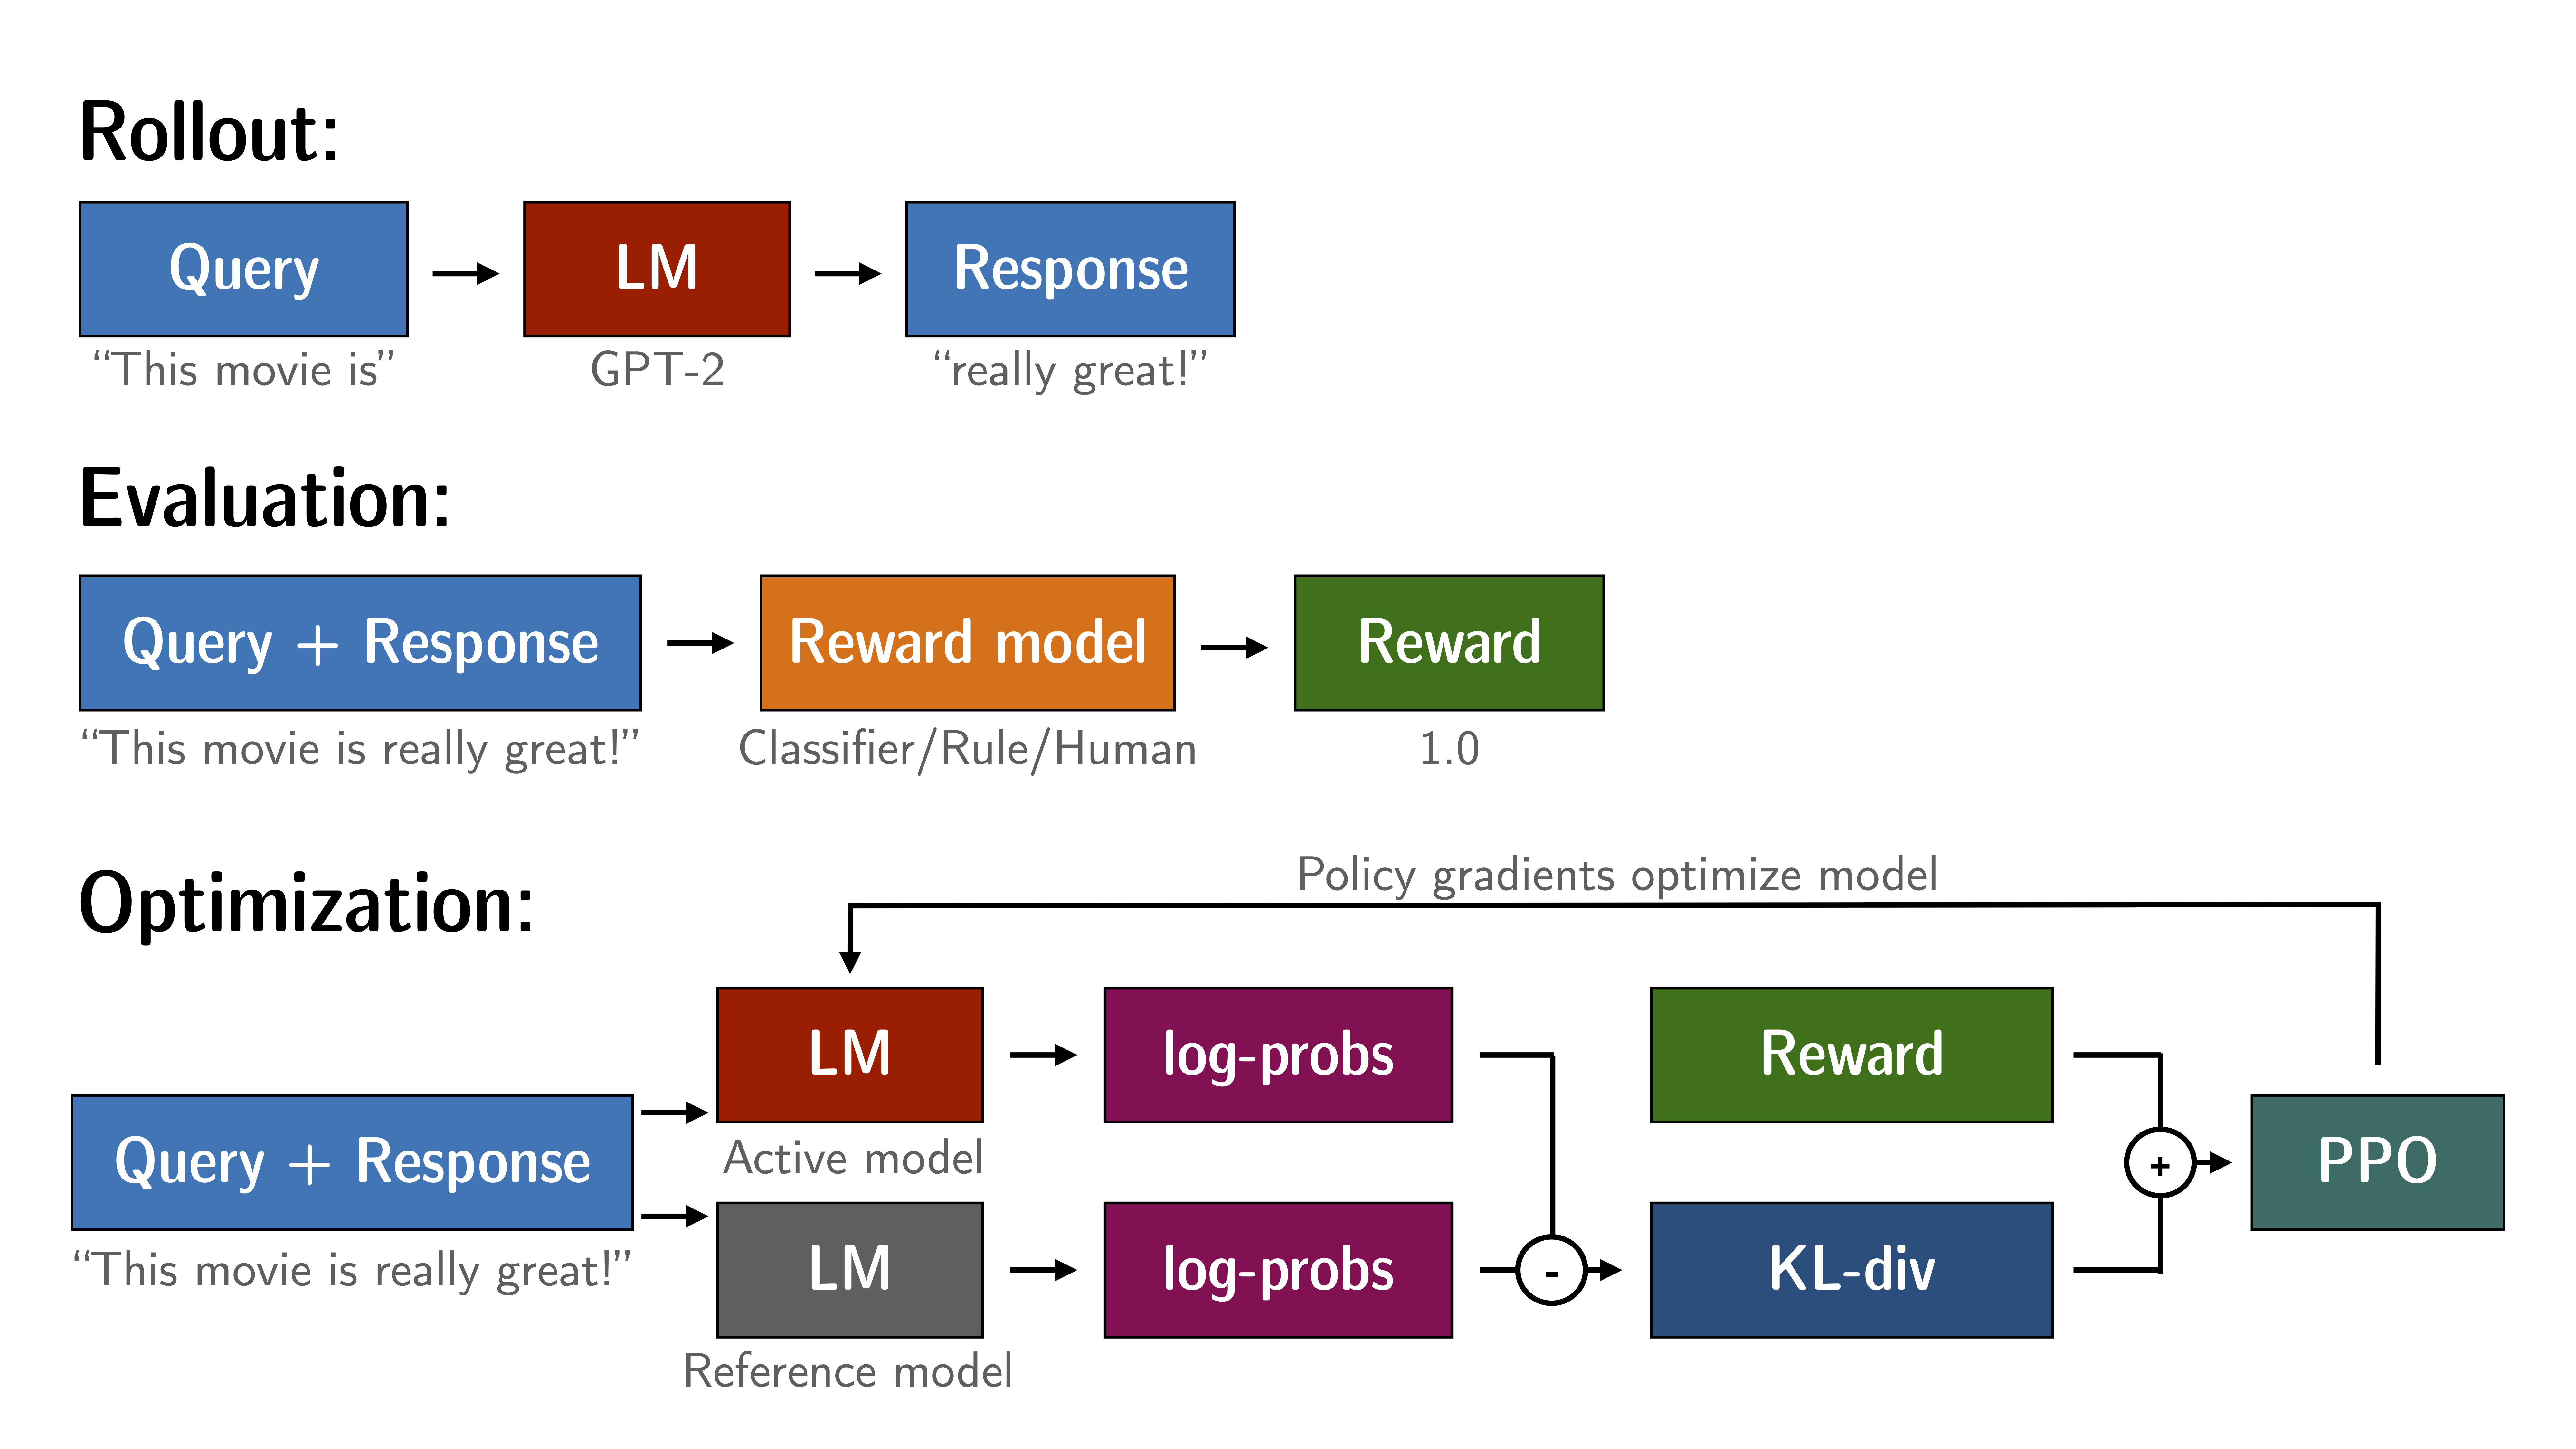

In [5]:
Image('../imgs/trl_overview.png', width=600)

- gpt-2 待 fine-tune 的生成 positive review 的生成式模型；
- distilbert 作为 reward model 去打分；

### dataset

### models

- model: 待对齐reward model，也即待 finetune model
- ref_model：作为 fine tune 的基线值，希望不偏离原始 model 太多，不 fine-tune
    - 初始时，model 与 ref_model 是一致的；
- reward model：score model，
    - fine-tune 好了的 model

### training